<a href="https://colab.research.google.com/github/Marcellinus08/Deep-Learning/blob/main/Auto_Encooder_and_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Library

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

Data Preparation

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

def show_reconstructions(model, images=X_valid, n_images=5):
    """Menampilkan gambar asli dan hasil rekonstruksinya."""
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])
    plt.show()

Stacked Denoising Autoencoder

In [4]:
denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]), # Warning: Prefer Input(shape) as the first layer in Sequential models.
    keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [5]:
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]), # Warning: Prefer Input(shape) as the first layer in Sequential models.
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer="nadam", metrics=['mse'])
history = denoising_ae.fit(X_train, X_train, epochs=10,validation_data=(X_valid, X_valid), verbose=1)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - loss: 0.3436 - mse: 0.0339 - val_loss: 0.2945 - val_mse: 0.0169
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - loss: 0.2931 - mse: 0.0171 - val_loss: 0.2892 - val_mse: 0.0151
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - loss: 0.2890 - mse: 0.0157 - val_loss: 0.2866 - val_mse: 0.0143
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 22s 9ms/step - loss: 0.2866 - mse: 0.0149 - val_loss: 0.2854 - val_mse: 0.0140
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 23s 10ms/step - loss: 0.2855 - mse: 0.0145 - val_loss: 0.2840 - val_mse: 0.0135
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - loss: 0.2845 - mse: 0.0143 - val_loss: 0.2832 - val_mse: 0.0132
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - loss: 0.2837 - mse: 0.0140 - val_loss: 0.2824 - val_mse: 0.0129
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 0.2831 - mse: 0.0137 - val_loss: 0.2818 - val_mse: 0.0127
Epoch 9/10
1719/1719 ━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


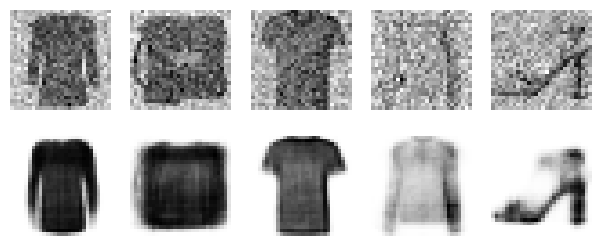

--------------------------------------------------


In [7]:
noise = keras.layers.GaussianNoise(0.2)
noisy_valid = noise(X_valid, training=True)
show_reconstructions(denoising_ae, noisy_valid)
print("-" * 50)

Variational Autoencoder

In [8]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return keras.backend.random_normal(tf.shape(log_var)) * keras.backend.exp(log_var / 2) + mean

codings_size = 10


In [9]:
inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

In [10]:
decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.Model(inputs=[decoder_inputs], outputs=[outputs])

In [11]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)

class LatentLoss(keras.layers.Layer):
    def call(self, inputs):
        codings_mean, codings_log_var = inputs
        latent_loss = -0.5 * keras.backend.sum(
            1 + codings_log_var - keras.backend.exp(codings_log_var) - keras.backend.square(codings_mean),
            axis=-1)
        self.add_loss(tf.reduce_mean(latent_loss) / 784.)
        return inputs

codings_mean, codings_log_var, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
latent_loss_layer = LatentLoss()([codings_mean, codings_log_var])
variational_ae = keras.Model(inputs=[inputs], outputs=[reconstructions])

In [12]:
variational_ae.compile(loss="binary_crossentropy", optimizer="nadam")
history = variational_ae.fit(X_train, X_train, epochs=10, batch_size=128,validation_data=(X_valid, X_valid), verbose=1)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_12']
Received: inputs=Tensor(shape=(None, 28, 28))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_19']
Received: inputs=Tensor(shape=(None, 10))
  warnings.warn(msg)


430/430 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.3842 - val_loss: 0.3070
Epoch 2/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.3017 - val_loss: 0.2971
Epoch 3/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.2945 - val_loss: 0.2932
Epoch 4/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.2907 - val_loss: 0.2907
Epoch 5/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.2885 - val_loss: 0.2891
Epoch 6/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.2867 - val_loss: 0.2882
Epoch 7/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.2862 - val_loss: 0.2872
Epoch 8/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.2852 - val_loss: 0.2864
Epoch 9/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.2847 - val_loss: 0.2861
Epoch 10/10
430/430 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.2836 - val_loss: 0.2855


In [13]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols * 1.5, n_rows * 1.5))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_19']
Received: inputs=Tensor(shape=(12, 10))
  warnings.warn(msg)


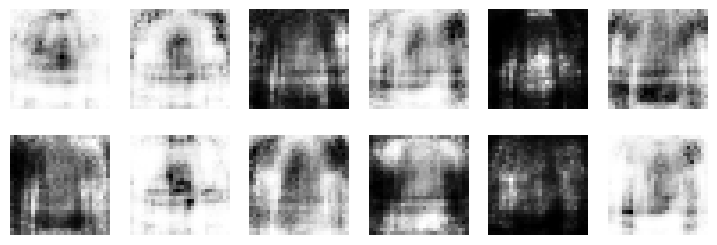

--------------------------------------------------


In [14]:
codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder.predict(codings)
plot_multiple_images(images, n_cols=6)
print("-" * 50)

Deep Convolutional GAN


In [15]:
codings_size = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="same", activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="same", activation="tanh")
])


In [16]:
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="same",
                        activation=keras.layers.LeakyReLU(0.2), input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="same",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
gan = keras.models.Sequential([generator, discriminator])

In [18]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")



In [19]:
X_train_gan = X_train.reshape(-1, 28, 28, 1) * 2. - 1.

In [20]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=5):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print(f"Epoch {epoch + 1}/{n_epochs}")
        for X_batch in dataset:
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            X_fake_and_real = tf.concat([generated_images, tf.cast(X_batch, tf.float32)], axis=0)
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)

            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        print("Evaluasi GAN: Gambar yang dihasilkan di akhir epoch")
        noise = tf.random.normal(shape=[batch_size, codings_size])
        generated_images = generator(noise)
        plot_multiple_images(generated_images, n_cols=8)


Epoch 1/5
Evaluasi GAN: Gambar yang dihasilkan di akhir epoch


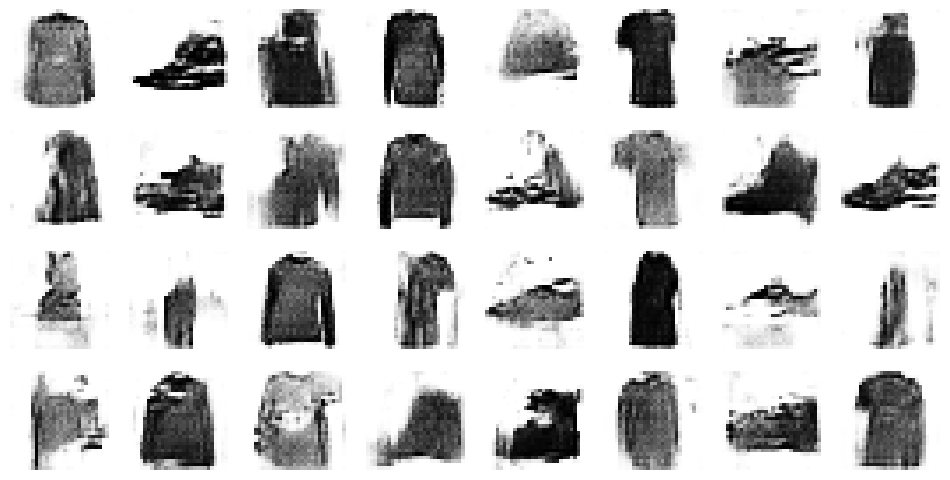

Epoch 2/5
Evaluasi GAN: Gambar yang dihasilkan di akhir epoch


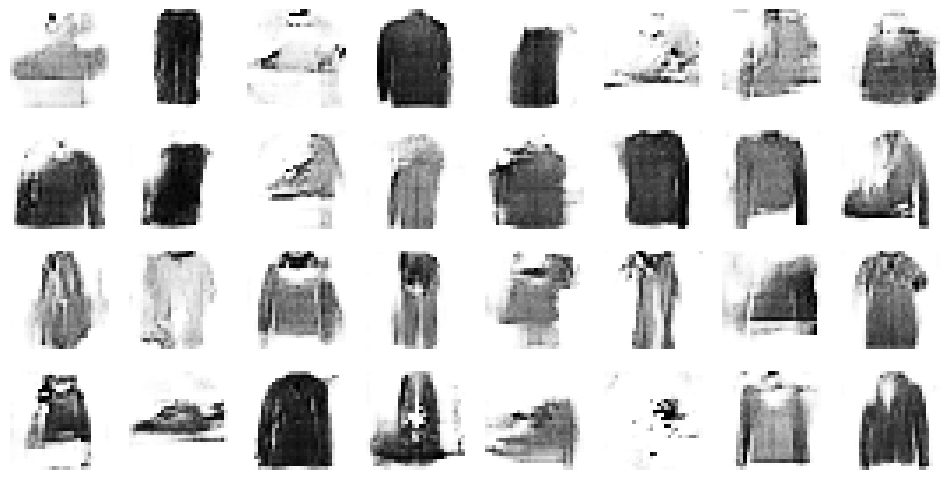

Epoch 3/5
Evaluasi GAN: Gambar yang dihasilkan di akhir epoch


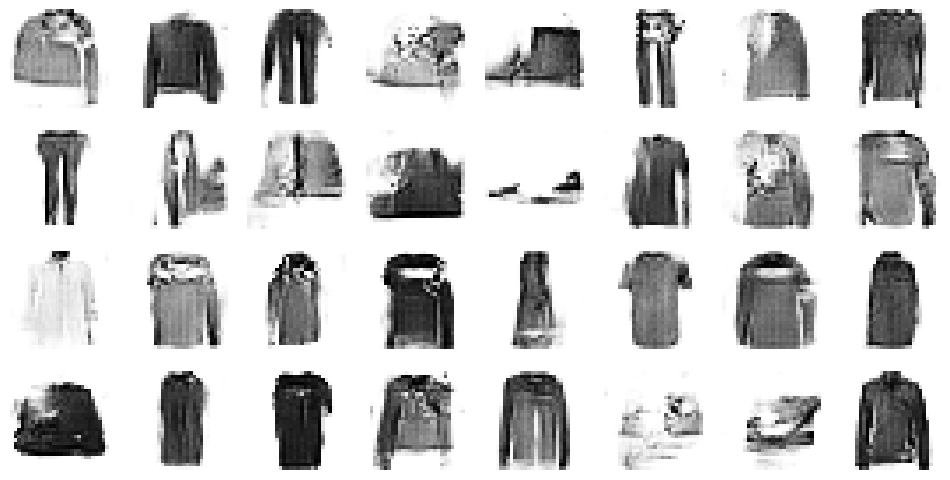

Epoch 4/5
Evaluasi GAN: Gambar yang dihasilkan di akhir epoch


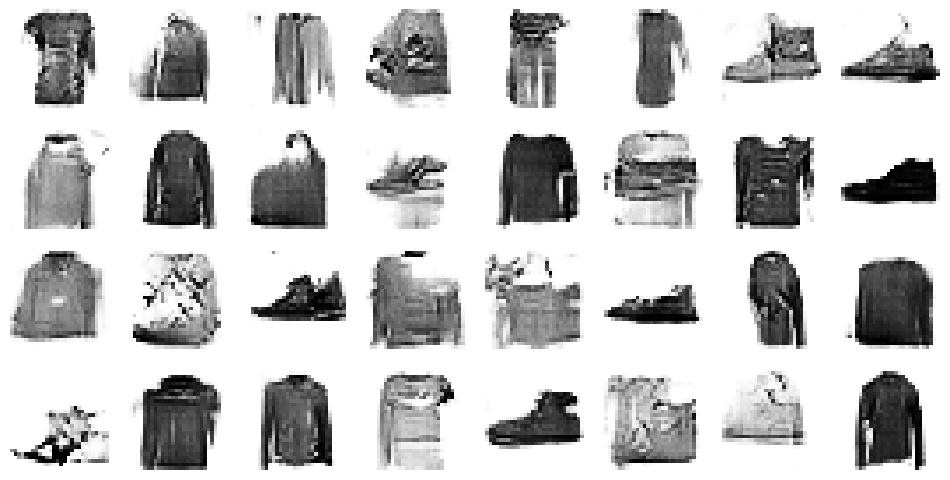

Epoch 5/5
Evaluasi GAN: Gambar yang dihasilkan di akhir epoch


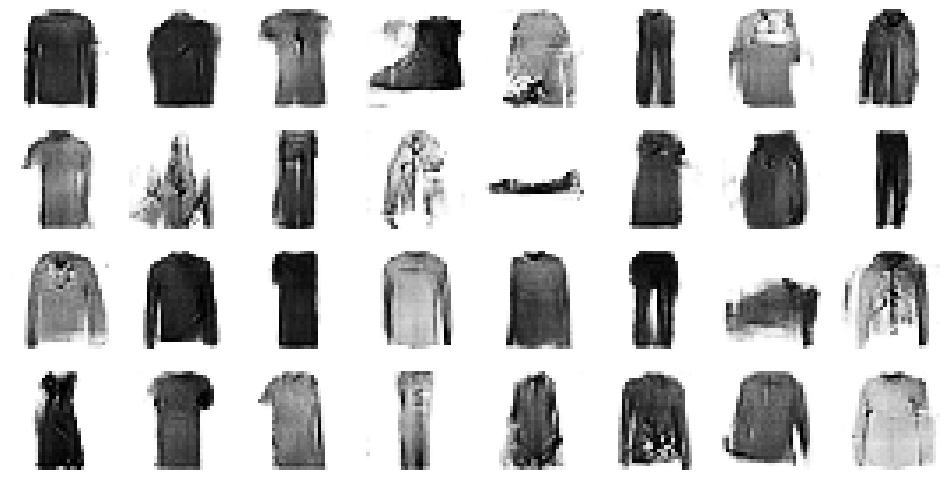

In [21]:
batch_size = 32
dataset_gan = tf.data.Dataset.from_tensor_slices(X_train_gan).shuffle(1000)
dataset_gan = dataset_gan.batch(batch_size, drop_remainder=True).prefetch(1)
train_gan(gan, dataset_gan, batch_size, codings_size, n_epochs=5)